<a href="https://colab.research.google.com/github/Yohanes213/Spot-the-mask/blob/main/Spot_the_Mask_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/driver/')

Mounted at /content/driver/


In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Reshape, LSTM, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical



In [ ]:
df = pd.read_csv('/content/driver/MyDrive/Spot the Mask Challenge/images/train_labels.csv')
df_sub = pd.read_csv('/content/driver/MyDrive/Spot the Mask Challenge/images/SampleSubmission (1).csv')

In [ ]:
df.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


In [ ]:
df_sub.head()

,image,target
0,aadawlxbmapqrblgxyzarhjasgiobu.png,0
1,abpxvdfyhaaohzcrngcucmhffwizxs.jpg,0
2,aclkjfvackiieiznzfcwienplielrj.jpg,0
3,aelkivmayxgsdjosiibfgmkvfrjvjk.jpg,0
4,aelzzshpfxerelefnkatpczktuxjln.jpg,0


In [ ]:
data=os.listdir("/content/driver/MyDrive/Spot the Mask Challenge/images/images")

In [ ]:
df['target'].value_counts(normalize='true')

0    0.507645
1    0.492355
Name: target, dtype: float64

<Axes: >

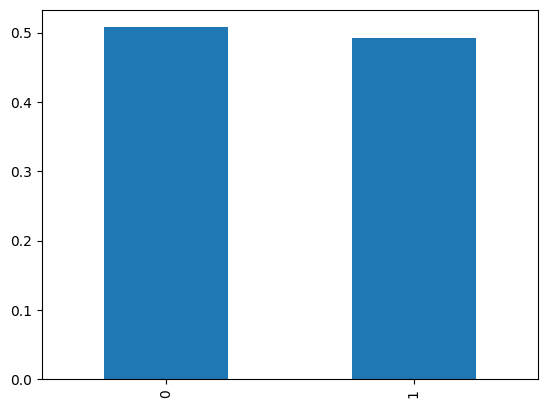

In [ ]:
df['target'].value_counts(normalize='true').plot.bar()

In [ ]:
df["target"] = df["target"].replace({0: 'unmask', 1: 'mask'})

In [ ]:
image_size = 224
input_shape = (image_size, image_size, 3)

batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

58889256/58889256 [==============================] - 2s 0us/step


In [ ]:
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output



x = Conv2D(64,(3,3),activation='relu')(last_output)
#pooling layer
#x = MaxPooling2D(2,2)(x)
#x = BatchNormalization()(x)
#convolution layer
x = Conv2D(128,(3,3),activation='relu')(x)
#pooling layer
x = MaxPooling2D(2,2)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

#o/p layer
x = Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

#model.compile(loss='binary_crossentropy',
 #             optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
  #            metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#earlystop = EarlyStopping(patience=10)
early_stop=EarlyStopping(monitor='val_accuracy',mode='max',verbose=1,patience=10, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5,min_lr=0.00001)
callbacks = [early_stop, learning_rate_reduction]

In [ ]:
train_df,validate_df=train_test_split(df,test_size=0.2,random_state=42)
#train_df = train_df.reset_index(drop='True')
#validate_df = validate_df.reset_index(drop='True')

<Axes: >

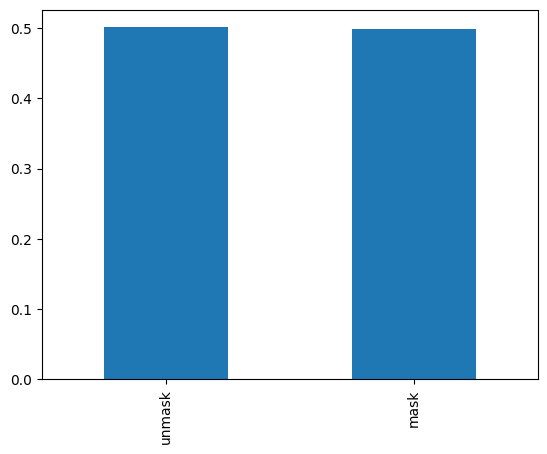

In [ ]:
train_df['target'].value_counts(normalize='true').plot.bar()

<Axes: >

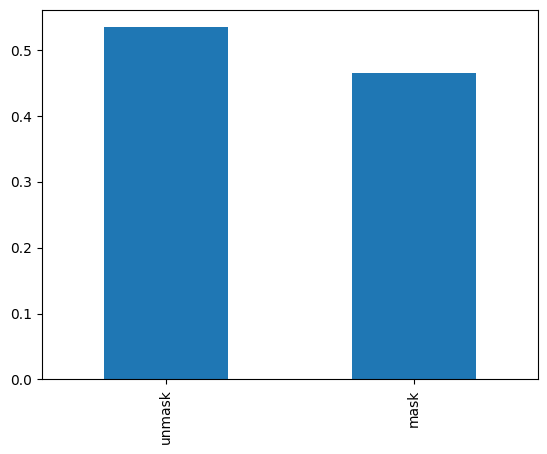

In [ ]:
validate_df['target'].value_counts(normalize='true').plot.bar()

In [ ]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [ ]:
train_datagen=ImageDataGenerator(
                    rotation_range=15,
                    rescale=1./255,
                    shear_range=0.1,
                    zoom_range=0.2, # zoom range (1-0.2 to 1+0.2)
                    horizontal_flip=True,
                    width_shift_range=0.1,
                    height_shift_range=0.1
                 )
train_generator=train_datagen.flow_from_dataframe(
                    dataframe=train_df,
                    directory="/content/driver/MyDrive/Spot the Mask Challenge/images/images",
                    x_col="image",
                    y_col="target",
                    target_size=(image_size,image_size),
                    class_mode='binary',
                    batch_size=batch_size
                )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    directory="/content/driver/MyDrive/Spot the Mask Challenge/images/images",
    x_col="image",
    y_col="target",
    target_size=(image_size,image_size),
    class_mode='binary',
    batch_size=batch_size
)

Found 1046 validated image filenames belonging to 2 classes.
Found 262 validated image filenames belonging to 2 classes.


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=100
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-36-92a83a936eea>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
69/69 [==============================] - 25s 348ms/step - loss: 0.3948 - accuracy: 0.8167 - val_loss: 1.5801 - val_accuracy: 0.4627 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 25s 362ms/step - loss: 0.2820 - accuracy: 0.8826 - val_loss: 0.9667 - val_accuracy: 0.5725 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 23s 336ms/step - loss: 0.2455 - accuracy: 0.9049 - val_loss: 0.8782 - val_accuracy: 0.6824 - lr: 0.0100
Epoch 4/100
69/69 [==============================] - 23s 336ms/step - loss: 0.2228 - accuracy: 0.9059 - val_loss: 0.2289 - val_accuracy: 0.8980 - lr: 0.0100
Epoch 5/100
69/69 [==============================] - 25s 358ms/step - loss: 0.1518 - accuracy: 0.9350 - val_loss: 0.2305 - val_accuracy: 0.8980 - lr: 0.0100
Epoch 6/100
69/69 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9321
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
69/69 [==============================] - 29s 

In [ ]:
model.evaluate_generator(validation_generator)

<ipython-input-37-8951cfd684a1>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validation_generator)


[0.22467491030693054, 0.9312977194786072]

In [ ]:
model.evaluate_generator(train_generator)

<ipython-input-38-e4ade065aa26>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_generator)


[0.014350783079862595, 0.9990440011024475]

In [ ]:
predictions = model.predict_generator(validation_generator)#, steps=test_generator.samples // batch_size)

# Convert the predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
y_true = validation_generator.classes

# Compute the confusion matrix
confusion_matrix1 = confusion_matrix(y_true, y_pred)

#
predictions = model.predict_generator(train_generator)#, steps=test_generator.samples // batch_size)

# Convert the predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
y_true = train_generator.classes

# Compute the confusion matrix
confusion_matrix2 = confusion_matrix(y_true, y_pred)

In [ ]:
confusion_matrix2

In [ ]:
confusion_matrix1

In [ ]:
from tensorflow.keras.layers import TimeDistributed

In [ ]:
pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")

In [ ]:
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True

last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

#x = Reshape((7,7, 512))(last_output)
#x = Reshape((1, 14, 512))(x)
#x = Reshape((7, 7 * 512))(last_output)

#x = LSTM(64, return_sequences=True)(last_output)
#x = BatchNormalization()(x)
#x = LSTM(128, return_sequences=True)(x)
#x = BatchNormalization()(x)

#x = Flatten()(x)

#o/p layer
#x = Dense(1,activation='sigmoid')(x)

# Add an LSTM layer
#x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Reshape((7 * 7, 512))(last_output)
x = LSTM(64, activation='relu')(x)

# Add a TimeDistributed layer around the Dense output layer
x = Reshape((1, 64))(x)

# Add a TimeDistributed layer around the Dense output layer
x = TimeDistributed(Dense(1, activation='sigmoid'))(x)
#x = TimeDistributed(Dense(1, activation='sigmoid'))(x)

model = Model(pre_trained_model.input, x)

#model.compile(loss='binary_crossentropy',
 #             optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
  #            metrics=['accuracy'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

In [ ]:
epochs=100
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-40-92a83a936eea>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
69/69 [==============================] - 562s 8s/step - loss: 7.6892 - accuracy: 0.4916 - val_loss: 8.2871 - val_accuracy: 0.4627 - lr: 0.0010
Epoch 2/100
69/69 [==============================] - 29s 424ms/step - loss: 7.7214 - accuracy: 0.4994 - val_loss: 8.2266 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 3/100
69/69 [==============================] - 30s 429ms/step - loss: 7.7092 - accuracy: 0.5002 - val_loss: 8.3476 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 4/100
69/69 [==============================] - ETA: 0s - loss: 7.7333 - accuracy: 0.4986
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
69/69 [==============================] - 30s 431ms/step - loss: 7.7333 - accuracy: 0.4986 - val_loss: 8.3476 - val_accuracy: 0.4588 - lr: 0.0010
Epoch 5/100
69/69 [==============================] - 29s 424ms/step - loss: 7.7465 - accuracy: 0.4978 - val_loss: 8.1057 - val_accuracy: 0.4745 - lr: 5.0000e-04
Epoch 6/100
25/69 [=========>....................] - E

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
!pip install efficientnet

In [ ]:
import efficientnet.keras as efn
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from keras.layers import GlobalAveragePooling2D

In [ ]:
pre_trained_model = efn.EfficientNetB0(weights="imagenet", include_top=False,input_shape=(224,224,3))

In [ ]:
#for layer in pre_trained_model.layers:
#  layer.trainable=False

last_layer = pre_trained_model.get_layer('top_activation')
last_output = last_layer.output



x = Conv2D(64,(3,3),activation='relu')(last_output)
#pooling layer
#x = MaxPooling2D(2,2)(x)
x = BatchNormalization()(x)
#convolution layer
#x = Conv2D(128,(2,2),activation='relu')(x)
#pooling layer
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

#x = Flatten()(x)

#o/p layer
x = Dense(2,activation='softmax')(x)

model = Model(pre_trained_model.input, x)

#model.compile(loss='binary_crossentropy',
 #             optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
  #            metrics=['accuracy'])

#model.summary()



In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Loss Function and its Parameters
adam = Adam(amsgrad=True)

# Compilation of Model
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

In [ ]:
#model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=15, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
    ModelCheckpoint('./Best.h5', monitor='val_loss', mode = 'min' , verbose=1, save_best_only=True, save_weights_only=False)
]

In [ ]:
epochs = 100
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate // batch_size,
    steps_per_epoch=total_train // batch_size,
    callbacks=callbacks
)

In [ ]:
model.evaluate_generator(train_generator)

In [ ]:
model.evaluate_generator(validation_generator)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
predictions = model.predict_generator(validation_generator)#, steps=test_generator.samples // batch_size)

# Convert the predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
y_true = validation_generator.classes

# Compute the confusion matrix
confusion_matrix1 = confusion_matrix(y_true, y_pred)

#

In [ ]:
tf.keras.metrics.Precision()(y_pred,y_true)

In [ ]:
tf.keras.metrics.Recall()(y_pred,y_true)

In [ ]:
confusion_matrix1

In [ ]:
predictions = model.predict_generator(train_generator)#, steps=test_generator.samples // batch_size)

# Convert the predictions to class labels
y_pred = np.argmax(predictions, axis=1)

# Get the true class labels from the test generator
y_true = train_generator.classes

# Compute the confusion matrix
confusion_matrix2 = confusion_matrix(y_true, y_pred)

#

In [ ]:
confusion_matrix2

In [ ]:
tf.keras.metrics.Precision()(y_pred,y_true)

In [ ]:
tf.keras.metrics.Recall()(y_pred,y_true)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_sub,
    directory="/content/driver/MyDrive/Spot the Mask Challenge/images/images",
    x_col="image",
    y_col=None,
    target_size=(image_size,image_size),
    class_mode=None,
    batch_size=batch_size
)

In [ ]:
target_predict = model.predict(test_generator)

In [ ]:
target_predict

In [ ]:
pred = np.argmax(target_predict,axis=1)

In [ ]:
pred

In [ ]:
submission = {k:v for k, v in zip(df_sub['image'], pred)}

In [ ]:
sub = pd.Series(submission).to_frame().reset_index()

In [ ]:
df_sub.head()

In [ ]:
sub.columns= [["image", "target"]]

In [ ]:
sub.head()

In [ ]:
sub['target'].value_counts()

In [ ]:
sub.to_csv("submission.csv", index=None)

In [ ]:
import pickle

# Save the model to a file
with open('my_model.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
from tensorflow.keras.applications import InceptionV3

In [ ]:
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Load the InceptionV3 model


# Freeze the weights of the InceptionV3 model
for layer in inception_v3.layers:
    layer.trainable = False


last_layer = inception_v3.get_layer('mixed10')
last_output = last_layer.output



x = Conv2D(64,(3,3),activation='relu')(last_output)
#pooling layer
#x = MaxPooling2D(2,2)(x)
#x = BatchNormalization()(x)
#convolution layer
x = Conv2D(128,(3,3),activation='relu')(x)
#pooling layer
#x = MaxPooling2D(2,2)(x)
x = BatchNormalization()(x)

x = Flatten()(x)

#o/p layer
x = Dense(1,activation='sigmoid')(x)

model = Model(inception_v3.input, x)

#model.compile(loss='binary_crossentropy',
 #             optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
  #            metrics=['accuracy'])

model.summary()


In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
epochs=100
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

In [ ]:
model.evaluate_generator(validation_generator)

In [ ]:
model.evaluate_generator(train_generator)